In [1]:
import json
import math

import time
import numpy as np

from scipy import interpolate
from scipy.interpolate import interpolate

from matplotlib import pyplot as plt

$\textbf{Plant}$

This class provides an interface to handle the binning of a trajectory to get the the conditional pmf of the plant.

In [2]:
class Plant:

    def __init__(self, x_max, x_min, u_max, u_min, x_discr, u_discr):
        # Bounds for u and x
        self.x_max = x_max
        self.x_min = x_min
        self.u_max = u_max
        self.u_min = u_min

        # Amount of bins (resolution) for u and x
        self.x_discr = x_discr
        self.u_discr = u_discr

        # Discretization step for x and u
        self.x_step = (self.x_max - self.x_min)/self.x_discr
        self.u_step = (self.u_max - self.u_min)/self.u_discr
    
        self.x_axis = [self.x_min + (i+0.5)*self.x_step for i in range(self.x_discr)]
        self.u_axis = [self.u_min + (j+0.5)*self.u_step for j in range(self.u_discr)]  

        self.full_joint = np.zeros((self.x_discr, self.u_discr, self.x_discr)) #Initializing f(x_k, u_k, x_{k-1}) (3D array)
        self.reduced_joint = np.zeros((self.x_discr, self.u_discr)) #Initializing f(u_k, x_{k-1}) (2D array)
        self.f_x = np.zeros((self.x_discr, self.u_discr, self.x_discr)) #Initializing f(x_k| u_k, x_{k-1}) (3D array)

    def getXdiscr(self):
        return self.x_discr

    def getUdiscr(self):
        return self.u_discr

    def getXmin(self):
        return self.x_min

    def getUmin(self):
        return self.u_min

    def getXmax(self):
        return self.x_max

    def getUmax(self):
        return self.u_max

    def getXstep(self):
        return self.x_step

    def getUstep(self):
        return self.u_step

    def getXaxis(self):
        return self.x_axis

    def getUaxis(self):
        return self.u_axis

    def getPlant(self, x, u):
        # Function that handles the binning of a trajectory
        # Given a history for the state and the input (ie two lists), browses each list and increments the appropriate histogram bins 
        for i in range(len(x)-1): #N-1 iterations (since we study consecutive pairs of states, one iteration less than the number of states)
            xkm1 = x[i] #x_{k-1}
            xk = x[i+1] #x_k
            uk = u[i+1] #u_k

            #Calculating the index from the min value and the discretization step
            indXkm1 = int((xkm1 - self.x_min)//self.x_step)
            indXk = int((xk - self.x_min)//self.x_step)
            indUk = int((uk - self.u_min)//self.u_step)
            self.full_joint[indXkm1][indUk][indXk] += 1 #Updating the full joint 'pmf'
            self.reduced_joint[indXkm1][indUk] += 1 #Updating the partial 'pmf'

        for i in range(self.x_discr): #For each x_{k-1}
            for j in range(self.u_discr): #For each u_k
                for k in range(self.x_discr): #For each x_k
                    if self.full_joint[i][j][k] == 0: #Failsafe to avoid dividing by zero
                        self.f_x[i][j][k] = 0 #If we've never encountered this state, let the conditionnal value be zero
                    else:
                        self.f_x[i][j][k] = self.full_joint[i][j][k]/self.reduced_joint[i][j] #Divide the full joint by the partial joint
   

$\textbf{GaussianPlant}$

This class extends the class Plant and provides an interface to get the the conditional pmf of the plant, using the explicit formula of the Gaussian.

If the chosen mode is "Analytic" the gaussian pmf of the plant is computed in the form $[mean, std]$, otherwise as a normal Gaussian distribution.

In [3]:
class GaussianPlant(Plant):

    def __init__(self, x_max, x_min, u_max, u_min, x_discr, u_discr, a, b, sigma, mode="analytic"):
        super().__init__(x_max, x_min, u_max, u_min, x_discr, u_discr)
        self.sigma = sigma
        self.a = a
        self.b = b
        self.mode = mode
        

    def getPlant(self, x = None, y = None):
        # Function for getting the plant (f_x or g_x) from the parameters.
        # The arguments are the linear parameters for the mean and the std.
        # The Gaussians are simply coded as [mean, std] to simplify calculations
        if self.mode == "analytic":
            self.f_x = np.zeros((self.x_discr, self.u_discr, 2)) # Initializing the empty array
        for i in range(self.x_discr): # Iterating over the state space for x_{k-1}
            x_km1 = self.x_min + (i+0.5)*self.x_step # Calculating x_{k-1}
            for j in range(self.u_discr): # Iterating over the action space for u_k
                u_k = self.u_min + (j+0.5)*self.u_step # Calculating u_k
                mu = self.a*x_km1 + self.b*u_k # Calculating the average of the Gaussian
                if self.mode == "analytic":
                    self.f_x[i][j] = [mu, self.sigma] # Adding the Gaussian in [mean, std] form to the array
                else:
                    self.f_x[i][j] = self.sample_gaussian(mu, self.sigma, self.x_axis)
        return(self.f_x)

    def sample_gaussian(self, mu, sigma, Ax):
        # Where Ax is the horizontal axis
        pmf = [0]*len(Ax) # Initializing the pmf
        for i in range(len(Ax)): # Iterating over the state space to calculate the elements of the pmf
            pmf[i] = np.exp(-0.5*((Ax[i]-mu)/sigma)**2)  # Using the explicit formula for the Gaussian
                                                         # The multiplicative factor is omitted as the pmf will be normalized
        S = np.sum(pmf) # Calculating the sum for normalization
        return([x/S for x in pmf])

$\textbf{NumericalSolver}$

This class provides an interface to perform the control from demonstration using numerical computing techniques.

The pmf of the agent and of the demonstrator can be any distribution.

In [4]:
class NumericalSolver:

    def __init__(self, f, g, g_u):
        self.f = f # Plant object of the agent
        self.g = g # Plant object of the demonstrator
        self.g_u = g_u # TargetPolicy object


    def DKL(self, f, g):
        # Kullback-Leibler divergence between two arrays, they have to be pmfs (ie histograms that sum to 1)
        return(np.sum([f[i]*math.log(f[i]/g[i]) for i in range(len(f)) if f[i]!=0 and g[i]!= 0]))

    def runFPD(self, xStart, tHor=0):

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        f_x = self.f.getPlant()
        g_x = self.g.getPlant()

        # Runs the control from demos algorithm, assuming the agent is at state xStart (given as an index!) with a time horizon tHor
        # Initializing zero gamma function
        gamma = np.zeros(x_discr)
        # If time horizon is greater than 0 we consider the states from the min between (xStart + time horizon -1) and 
        # (d_discr-1) (in order to not exceed the dimension of the array) to (xStart + 1)
        if tHor > 0: 
            stateAtTime = list(range(min(xStart + tHor-1, x_discr - 2), xStart + 1, -1))
        # Else we don't take into account the future states, but we consider only the next time step
        else: 
            stateAtTime = [] 
        
        # We calculate gamma from xStart + time horizon to xStart + 1
        for xk, uk in zip(stateAtTime, stateAtTime):
            # We initialize an auxiliary array, which we will use to calculate gamma_k(x_k)
            gammaArray = np.zeros(u_discr)
            # We get f(x_{k+1}|x_k,u_{k+1})
            plant = f_x[xk][uk+1] 
            # We get g(x_{k+1}|x_k,u_{k+1})
            target_plant = g_x[xk][uk+1]
            # We build the array with the exp of the numeric DKL of the 'future' plants
            gammaArray[uk+1] = np.exp(-self.DKL(plant, target_plant))
            # Finally we calculate gamma, which is the log of the expectation of our auxiliary array
            gamma[xk] = np.log(np.dot(self.g_u.target_policy(xk),gammaArray)) 
        
        # Previous state x_(k-1)
        xkm1 = xStart  
        policy = np.zeros(u_discr)
        # We extract the corresponding target policy, g(u_k|x_{k-1}) 
        target_pol = self.g_u.target_policy(xkm1) 
        for u in range(u_discr): 
            # We get f(x_{k}|x_{k - 1}, u_k)
            plant = f_x[xkm1][u]
            # We get g(x_{k}|x_{k - 1}, u_k)
            target_plant = g_x[xkm1][u]
            # We sample plant for expectations
            policy[u] = target_pol[u]*np.exp(-self.DKL(plant, target_plant) + np.dot(plant,gamma))
        # We calculate the integral
        S = np.sum(policy)
        # We return the normalized result
        return([elt/S for elt in policy]) 

    def closedLoop(self, tHor=0):

        position = []
        speed = []
        x = 0

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        x_step = self.f.getXstep()
        u_step = self.f.getUstep()

        u_min = self.f.getUmin()
        x_min = self.f.getXmin()

        f_x = self.f.getPlant()

        while(x < x_discr-20):
            policy = self.runFPD(x, tHor) # We get the optimal policy
            u = np.random.choice(range(u_discr), p=policy) # We choose a random index u from the policy according to the distribution of the policy
            plant = f_x[x][u] # We get the conditional pmf of x_k: f(x_k|x_{k-1}, u_k)
            # We get the new state from the plant
            x = np.random.choice(range(x_discr), p=plant)
            x = max(x, 0)

            # We compute the value of state from the state index
            trueX = x_min + x_step*x

            # We compute the value of input from the input index
            trueU = u_min + u_step*u
            
            position.append(trueX)
            speed.append(trueU)

            print("Speed: " + str(trueU) + " km/h")
            print("New position: " + str(trueX) + " m")
    
        plt.figure(figsize=(8, 6), dpi=80)
        plt.subplot(2,1,1)
        plt.title("Simulation of the closed loop")
        plt.ylabel(r'Position $(m)$', fontsize=12)
        plt.plot(position)
        
        plt.subplot(2,1,2)
        plt.xlabel(r'Time $(s)$', fontsize=12)
        plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
        plt.plot(speed)
        plt.show()

$\textbf{AnalyticalSolver}$

This class provides an interface to perform the control from demonstration using analytic computing techniques, in particular using the explicit formula of the Gaussian.

The pmf of the agent and of the demonstrator have to be Gaussian distribution.

In [5]:
class AnalyticalSolver(NumericalSolver):

    def __init__(self, f, g, g_u):
        super().__init__(f, g, g_u)

    def DKL(self, f, g):
        mu1 = f[0] #Extracting means
        mu2 = g[0]
        sigma1 = f[1] #Extracting stds
        sigma2 = g[1]
        
        el1 = math.log(sigma1/sigma2) # Calculating the sub-elements of the formula
        el2 = sigma1*sigma1 + (mu1-mu2)*(mu1-mu2)
        el3 = 2*sigma2*sigma2
        
        return(el1 + el2/el3 - 0.5)

    def runFPD(self, xStart, tHor=0):

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        f_x = self.f.getPlant()
        g_x = self.g.getPlant()

        #Runs the control from demos algorithm, assuming the agent is at state xStart (given as an index!) with a time horizon tHor
        #Initializing zero gamma function
        gamma = np.zeros(x_discr)
        # If time horizon is greater than 0 we consider the states from the min between (xStart + time horizon -1) and
        # (d_discr-1) (in order to not exceed the dimension of the array) to (xStart + 1)
        if tHor >0: 
            stateAtTime = list(range(min(xStart + tHor-1, x_discr - 2), xStart + 1, -1))
        # Else we don't take into account the future states, but we consider only the next time step
        else: 
            stateAtTime = [] 
        
        # We calculate gamma from xStart + time horizon to xStart + 1
        for xk, uk in zip(stateAtTime, stateAtTime):
            # We initialize an auxiliary array, which we will use to calculate gamma_k(x_k)
            gammaArray = np.zeros(u_discr)
            # We get f(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
            plant = f_x[xk][uk+1]
            # We get g(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
            target_plant = g_x[xk][uk+1]
            # We build the array with the exp of the analytic DKL of the 'future' plants
            gammaArray[uk+1] = np.exp(-self.DKL(plant, target_plant))
            # Finally we calculate gamma, which is the log of the expectation of our auxiliary array
            gamma[xk] = np.log(np.dot(self.g_u.target_policy(xk),gammaArray)) 
        
        # Previous state x_(k-1)
        xkm1 = xStart  
        policy = np.zeros(u_discr)
        # We extract the corresponding target policy, g(u_k|x_{k-1})
        target_pol = self.g_u.target_policy(xkm1)
        for u in range(u_discr):
            # We get f(x_{k}|x_{k - 1}, u_k)
            plant = f_x[xkm1][u]
            # We get g(x_{k}|x_{k - 1}, u_k)
            target_plant = g_x[xkm1][u]
            # We sample plant for expectations
            policy[u] = target_pol[u]*np.exp(-self.DKL(plant, target_plant) + np.dot(self.f.sample_gaussian(plant[0],plant[1], self.f.getXaxis()), gamma))
        # We calculate the integral
        S = np.sum(policy)
        # We return the normalized result
        return([elt/S for elt in policy]) 

    def closedLoop(self, tHor=0):

        position = []
        speed = []
        x = 0

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        x_step = self.f.getXstep()
        u_step = self.f.getUstep()

        u_min = self.f.getUmin()

        f_x = self.f.getPlant()

        while(x < x_discr - 20):
            policy = self.runFPD(x, tHor) # We get the optimal policy
            u = np.random.choice(range(u_discr), p=policy) # We choose a random index u from the policy according to the distribution of the policy
            plant = f_x[x][u] # We get the conditional pmf of x_k: f(x_k|x_{k-1}, u_k)
            # We get the new state from the plant
            trueX = np.random.normal(plant[0],plant[1])
            x = round(trueX/x_step)

            x = max(x, 0)

            # We compute the value of input from the input index
            trueU = u_min + u_step*u
            
            position.append(trueX)
            speed.append(trueU)

            print("Speed: " + str(trueU) + " km/h")
            print("New position: " + str(trueX) + " m")
    
        plt.figure(figsize=(8, 6), dpi=80)
        plt.subplot(2,1,1)
        plt.title("Simulation of the closed loop")
        plt.ylabel(r'Position $(m)$', fontsize=12)
        plt.plot(position)
        
        plt.subplot(2,1,2)
        plt.xlabel(r'Time $(s)$', fontsize=12)
        plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
        plt.plot(speed)
        plt.show()

$\textbf{TargetPolicy}$

This class provides an interface to obtain the probability distribution of the control input given the previous state.

In [6]:
class TargetPolicy:

    def __init__(self, g, fmean, fstd):
        self.g = g
        self.g_u = [fmean(self.g.getXaxis()), fstd(self.g.getXaxis())]

    def target_policy(self, indx):
        return(self.g.sample_gaussian(self.g_u[0][indx], self.g_u[1][indx], self.g.getUaxis())) 

$\textbf{System parameters}$

In [7]:
#Bounds for u (velocity) and x (distance)
v_min = 15
v_max = 85

d_min = 0
d_max = 1500

#Amount of bins (resolution) for u and x
v_discr = 100
d_discr = 100

In [8]:
#Parameters for f(x_k|x_{k-1},u_k)
a_c = 0.982
b_c = 0.2591
sigma_c = 13.059

#Parameters for g(x_k|x_{k-1},u_k)
a_e = 0.9811
b_e = 0.2723
sigma_e = 8.811

$\textbf{Target policy}$

In [9]:
# Target policy
f1 = open('train_mean.json')
f2 = open('train_std.json')

means = json.load(f1)
std = json.load(f2)

# means["x"] and means["y"] are arrays of values used to approximate some function g(u_k|x_{k_1}). 
fmean = interpolate.interp1d(means['x'],means['y'], fill_value="extrapolate")
fstd = interpolate.interp1d(std['x'],std['y'], fill_value="extrapolate")

In [10]:
f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "analytic")
g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "analytic")
target_policy = TargetPolicy(g, fmean, fstd)

$\textbf{Closed loop simulation using analytic solver}$

Speed: 54.199999999999996 km/h
New position: 4.7148752383438115 m
Speed: 55.599999999999994 km/h
New position: 34.9151650359122 m
Speed: 57.0 km/h
New position: 55.438482060207 m
Speed: 66.8 km/h
New position: 84.42406471317746 m
Speed: 60.5 km/h
New position: 145.4026777697443 m
Speed: 54.199999999999996 km/h
New position: 166.524267888544 m
Speed: 69.6 km/h
New position: 169.62981552047012 m
Speed: 57.0 km/h
New position: 187.94884537799737 m
Speed: 57.0 km/h
New position: 214.77604428590402 m
Speed: 61.9 km/h
New position: 236.25593030762582 m
Speed: 43.7 km/h
New position: 265.4283240664064 m
Speed: 52.099999999999994 km/h
New position: 290.35415435124156 m
Speed: 56.3 km/h
New position: 320.4438517133721 m
Speed: 57.0 km/h
New position: 339.52714119100017 m
Speed: 61.199999999999996 km/h
New position: 364.0156313623208 m
Speed: 54.199999999999996 km/h
New position: 380.7519277928816 m
Speed: 59.099999999999994 km/h
New position: 378.39839204871765 m
Speed: 58.4 km/h
New position: 

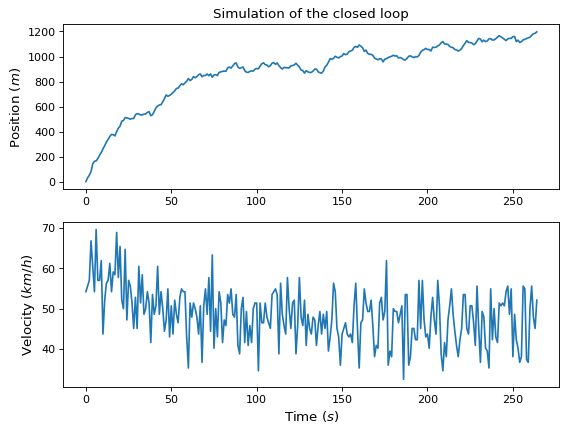

In [11]:
solver = AnalyticalSolver(f, g, target_policy)
solver.closedLoop()

$\textbf{Closed loop simulation using numeric solver}$

In [12]:
f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "numeric")
g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "numeric")
target_policy = TargetPolicy(g, fmean, fstd)

In [13]:
solver = NumericalSolver(f, g, target_policy)
solver.closedLoop()

Speed: 69.6 km/h
New position: 30.0 m
Speed: 55.599999999999994 km/h
New position: 15.0 m
Speed: 54.9 km/h
New position: 30.0 m
Speed: 66.8 km/h
New position: 45.0 m
Speed: 60.5 km/h
New position: 45.0 m
Speed: 48.599999999999994 km/h
New position: 45.0 m
Speed: 58.4 km/h
New position: 45.0 m
Speed: 58.4 km/h
New position: 45.0 m
Speed: 54.199999999999996 km/h
New position: 45.0 m
Speed: 58.4 km/h
New position: 60.0 m
Speed: 61.199999999999996 km/h
New position: 60.0 m
Speed: 57.0 km/h
New position: 60.0 m
Speed: 63.3 km/h
New position: 90.0 m
Speed: 44.4 km/h
New position: 105.0 m
Speed: 51.4 km/h
New position: 105.0 m
Speed: 66.8 km/h
New position: 105.0 m
Speed: 59.099999999999994 km/h
New position: 135.0 m
Speed: 59.099999999999994 km/h
New position: 150.0 m
Speed: 59.099999999999994 km/h
New position: 165.0 m
Speed: 61.9 km/h
New position: 210.0 m
Speed: 55.599999999999994 km/h
New position: 210.0 m
Speed: 45.8 km/h
New position: 225.0 m
Speed: 57.699999999999996 km/h
New position

KeyboardInterrupt: 

$\textbf{Comparing then elapsed time as d\_discr varies}$

In [ ]:
dict = {}

for i in range(100, 900, 100):
    v_discr = i
    d_discr = i   
    f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "analytic")
    g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "analytic")
    target_policy = TargetPolicy(g, fmean, fstd)

    solver = AnalyticalSolver(f, g, target_policy)
    t = time.time()
    solver.closedLoop()
    elapsed = time.time() - t
    del f
    del g
    del target_policy
    dict[i] = elapsed

In [ ]:
discr = [d for d in dict.keys()]
elapsed = [t for t in dict.values()]

plt.title(r'Time elapsed for each $d\_discr$')
plt.xlabel(r'$d\_discr$', fontsize=12)
plt.ylabel(r'Time $(s)$', fontsize=12)
plt.plot(discr, elapsed, 'bo')
plt.show()
plt.savefig("elapsed")